In [ ]:
!pip install soundfile simpleaudio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 27.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for simpleaudio: filename=simpleaudio-1.0.4-cp311-cp311-linux_x86_64.whl size=2054420 sha256=2dcad71114902327e3850b4795b29994a0dd33e33c94e1afc98ccc1661ff6525
  Stored in directory: /root/.cache/pip/wheels/44/74/11/9d2cf6ddf5d0dcc7750484a371b92fdb036f5496d1d4b42d08
Successfully built simpleaudio


In [ ]:
!pip install librosa scipy

## LOADING THE SPEECH SIGNAL

In [26]:
file_path = "/content/LJ001-0014.wav"
waveform, sample_rate = torchaudio.load(file_path)

## Loading the pretrained model and processor

In [28]:
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-960h")
phoneme_dict = cmudict.dict()

def get_phonemes(word):
    word = word.lower()
    return phoneme_dict.get(word, ["UNKNOWN"])

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Audio preprocessing (converting to mono and resampling to 16kHz)

In [29]:
waveform = torch.mean(waveform, dim=0, keepdim=True)
waveform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)(waveform)

## Convert waveform to input format


In [30]:
waveform_np = waveform.squeeze().numpy()
processed_audio = processor(waveform_np, return_tensors="pt", sampling_rate=16000)
input_values = processed_audio.input_values

# Run model inference
with torch.no_grad():
    predictions = model(input_values)

## Convert predictions to text and words to phenomes


In [31]:

predicted_ids = torch.argmax(predictions.logits, dim=-1)
phoneme_list = processor.batch_decode(predicted_ids)
transcription = phoneme_list[0]
phoneme_output = [get_phonemes(word) for word in transcription.split()]
print("Recognized Text:", transcription)
print("Phonemes:", phoneme_output)

Recognized Text: AND IT WAS A MATTER OF COURSE THAT IN THE MIDDLE AGES WHEN THE CRAFTSMEN TOOK CARE THAT BEAUTIFUL FORMS SHOULD ALWAYS BE A PART OF THEIR PRODUCTIONS WHATEVER THEY WERE
Phonemes: [[['AH0', 'N', 'D'], ['AE1', 'N', 'D']], [['IH1', 'T'], ['IH0', 'T']], [['W', 'AA1', 'Z'], ['W', 'AH1', 'Z'], ['W', 'AH0', 'Z'], ['W', 'AO1', 'Z']], [['AH0'], ['EY1']], [['M', 'AE1', 'T', 'ER0']], [['AH1', 'V'], ['AH0', 'V']], [['K', 'AO1', 'R', 'S']], [['DH', 'AE1', 'T'], ['DH', 'AH0', 'T']], [['IH0', 'N'], ['IH1', 'N']], [['DH', 'AH0'], ['DH', 'AH1'], ['DH', 'IY0']], [['M', 'IH1', 'D', 'AH0', 'L']], [['EY1', 'JH', 'AH0', 'Z'], ['EY1', 'JH', 'IH0', 'Z']], [['W', 'EH1', 'N'], ['HH', 'W', 'EH1', 'N'], ['W', 'IH1', 'N'], ['HH', 'W', 'IH1', 'N']], [['DH', 'AH0'], ['DH', 'AH1'], ['DH', 'IY0']], [['K', 'R', 'AE1', 'F', 'T', 'S', 'M', 'EH0', 'N'], ['K', 'R', 'AE1', 'F', 'S', 'M', 'EH0', 'N']], [['T', 'UH1', 'K']], [['K', 'EH1', 'R']], [['DH', 'AE1', 'T'], ['DH', 'AH0', 'T']], [['B', 'Y', 'UW1', 'T', 

## Extracting phoneme segment based on time


In [32]:
start_time = 1.0
end_time = 1.5
start_sample = int(start_time * 16000)
end_sample = int(end_time * 16000)
phoneme_segment = waveform[:, start_sample:end_sample]

## Align with recognised phenome

In [33]:
total_samples = waveform.size(1)
segment_ratio = start_sample / total_samples
num_words = len(transcription.split())
word_index = int(segment_ratio * num_words)
aligned_word = transcription.split()[word_index] if num_words > 0 else ''
aligned_phoneme = get_phonemes(aligned_word)

## Plot waveform of extracted phoneme


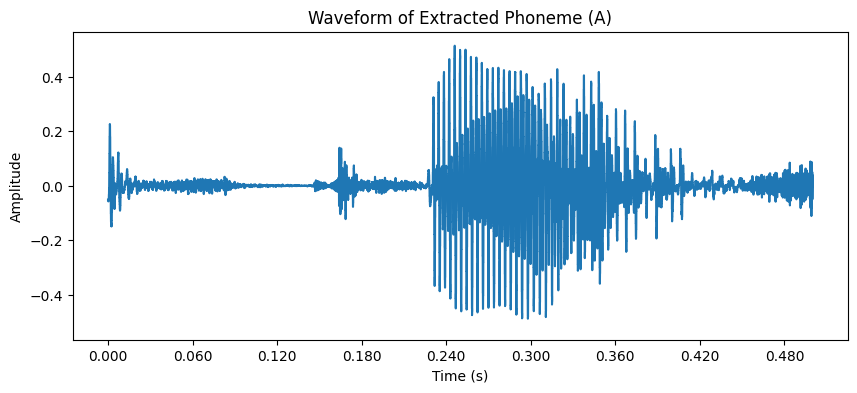

Aligned Word: A
Phonemes for 'A': [['AH0'], ['EY1']]


In [35]:
phoneme_array = phoneme_segment.numpy()
samples = phoneme_array.flatten()
plt.figure(figsize=(10, 4))
librosa.display.waveshow(samples, sr=16000)
plt.title(f"Waveform of Extracted Phoneme ({aligned_word})")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

print(f"Aligned Word: {aligned_word}")
print(f"Phonemes for '{aligned_word}': {aligned_phoneme}")